# Meta Data
Assume user downloaded archive.zip from Kaggle,
renamed the file BuildingData.zip,
and stored the file in the data subdirectory.
Assume the zip file contains the metadata.csv file.  

In [1]:
DATAPATH=''
try:
    # On Google Drive, set path to my drive / data directory.
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    # On home computer, set path to local data directory.
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"

ZIP_FILE='BuildingData.zip'
ZIP_PATH = DATAPATH+ZIP_FILE
META_FILE='metadata.csv'
MODEL_FILE='Model'  # will be used later to save models

In [2]:
from os import listdir
import csv
from zipfile import ZipFile
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)

In [3]:
def read_csv_to_numpy(filename): # array of string, header=row[0]
    with open(ELEC_PATH,'r') as handle:
        data_iter = csv.reader(handle,delimiter = ',',quotechar = '"')
        data = [data for data in data_iter]
        return np.asarray(data, dtype = None)
# Pandas incorporates column headers, row numbers, timestamps, and NaN for missing values.
def read_csv_to_panda(filename): # pandas data frame
    return pd.read_csv(filename)
def read_zip_to_panda(zip_filename,csv_filename):
    zip_handle = ZipFile(zip_filename)
    csv_handle = zip_handle.open(csv_filename)
    panda = pd.read_csv(csv_handle)
    return panda

In [4]:
meta_df = read_zip_to_panda(ZIP_PATH,META_FILE)
meta_df

,building_id,site_id,building_id_kaggle,site_id_kaggle,primaryspaceusage,sub_primaryspaceusage,sqm,sqft,lat,lng,...,yearbuilt,date_opened,numberoffloors,occupants,energystarscore,eui,site_eui,source_eui,leed_level,rating
0,Panther_lodging_Dean,Panther,NaN,0.0,Lodging/residential,Residence Hall,508.8,5477.0,28.517689,-81.379039,...,1989.0,NaN,NaN,NaN,NaN,271,NaN,NaN,None,NaN
1,Panther_lodging_Shelia,Panther,NaN,0.0,Lodging/residential,Residence Hall,929.0,10000.0,28.517689,-81.379039,...,1992.0,NaN,NaN,NaN,NaN,62,NaN,NaN,None,NaN
2,Panther_lodging_Ricky,Panther,NaN,0.0,Lodging/residential,Residence Hall,483.1,5200.0,28.517689,-81.379039,...,2016.0,NaN,NaN,NaN,NaN,534,NaN,NaN,None,NaN
3,Panther_education_Rosalie,Panther,0.0,0.0,Education,Research,690.5,7432.0,28.517689,-81.379039,...,2008.0,NaN,NaN,NaN,NaN,276,NaN,NaN,None,NaN
4,Panther_education_Misty,Panther,1.0,0.0,Education,Research,252.7,2720.0,28.517689,-81.379039,...,2004.0,NaN,NaN,NaN,NaN,375,NaN,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631,Mouse_health_Estela,Mouse,NaN,NaN,Healthcare,Hospital,17193.0,185064.0,51.521939,-0.120069,...,1936.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,F
1632,Mouse_health_Ileana,Mouse,NaN,NaN,Healthcare,Hospital,5399.0,58114.0,51.521939,-0.120069,...,1954.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,F
1633,Mouse_health_Buddy,Mouse,NaN,NaN,Healthcare,Hospital,1749.0,18826.0,51.521939,-0.120069,...,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,F
1634,Mouse_lodging_Vicente,Mouse,NaN,NaN,Lodging/residential,Hotel,3489.0,37555.0,51.521939,-0.120069,...,2006.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,F


In [5]:
print("Columns:\n",meta_df.columns)
print("Shape:",meta_df.shape)
NUM_ROWS=meta_df.shape[0]
NUM_COLS=meta_df.shape[1]

Columns:
 Index(['building_id', 'site_id', 'building_id_kaggle', 'site_id_kaggle',
       'primaryspaceusage', 'sub_primaryspaceusage', 'sqm', 'sqft', 'lat',
       'lng', 'timezone', 'electricity', 'hotwater', 'chilledwater', 'steam',
       'water', 'irrigation', 'solar', 'gas', 'industry', 'subindustry',
       'heatingtype', 'yearbuilt', 'date_opened', 'numberoffloors',
       'occupants', 'energystarscore', 'eui', 'site_eui', 'source_eui',
       'leed_level', 'rating'],
      dtype='object')
Shape: (1636, 32)


In [6]:
# Pandas statistics per column. Counts excludes NaN columns and values.
meta_df.describe()

,building_id_kaggle,site_id_kaggle,sqm,sqft,lat,lng,yearbuilt,numberoffloors,occupants
count,1449.000000,1599.000000,1636.000000,1636.000000,1399.000000,1399.000000,817.000000,441.000000,230.000000
mean,724.000000,6.722326,8224.033068,88522.795232,39.996887,-73.779899,1968.236230,3.614512,263.217391
std,418.434583,4.943530,10050.121946,108178.666361,7.403876,36.795109,30.935801,3.250338,401.643279
min,0.000000,0.000000,26.300000,283.000000,28.517689,-122.260729,1900.000000,1.000000,0.000000
25%,362.000000,3.000000,1936.925000,20849.000000,33.424425,-97.743100,1949.000000,1.000000,15.000000
50%,724.000000,5.000000,5074.400000,54620.500000,38.903504,-77.005349,1971.000000,2.000000,100.000000
75%,1086.000000,12.000000,10360.675000,111521.000000,44.978782,-76.485292,1994.000000,5.000000,314.500000
max,1448.000000,15.000000,81290.100000,875000.000000,53.349800,6.260300,2017.000000,26.000000,2380.000000


In [7]:
print("For each column, number of rows in which column is not null:")
print(meta_df.count(axis=0))

For each column, number of rows in which column is not null:
building_id              1636
site_id                  1636
building_id_kaggle       1449
site_id_kaggle           1599
primaryspaceusage        1615
sub_primaryspaceusage    1615
sqm                      1636
sqft                     1636
lat                      1399
lng                      1399
timezone                 1636
electricity              1578
hotwater                  185
chilledwater              555
steam                     370
water                     146
irrigation                 37
solar                       5
gas                       177
industry                  579
subindustry               579
heatingtype               215
yearbuilt                 817
date_opened                21
numberoffloors            441
occupants                 230
energystarscore           163
eui                       299
site_eui                  163
source_eui                163
leed_level                136
rating   

In [8]:
print("Here are the solar buildings:")
for i in range(0,NUM_ROWS):
    row=meta_df.iloc[i]
    bldg=row['building_id']
    solar=row['solar']
    if pd.notnull(solar):
        print(bldg,solar)

Here are the solar buildings:
Bobcat_education_Coleman Yes
Bobcat_education_Alissa Yes
Bobcat_office_Justine Yes
Bobcat_other_Timothy Yes
Bobcat_education_Dylan Yes


In [9]:
print("Energy type columns contain Yes or nan (not a number).")
energy_types=['electricity','hotwater','chilledwater','steam','water','irrigation','solar','gas']
for col in energy_types:
    print(col,meta_df[col].unique())

Energy type columns contain Yes or nan (not a number).
electricity [nan 'Yes']
hotwater [nan 'Yes']
chilledwater [nan 'Yes']
steam [nan 'Yes']
water [nan 'Yes']
irrigation ['Yes' nan]
solar [nan 'Yes']
gas ['Yes' nan]


In [10]:
print("But buildings can have zero, one, or many energy types.")
show_zero = True
show_mult = True
for i in range(0,NUM_ROWS):
    row=meta_df.iloc[i]
    bldg=row['building_id']
    cnt = 0
    if row['electricity']=='Yes':
        cnt += 1
    if row['hotwater']=='Yes':
        cnt += 1
    if cnt==0 and show_zero:
        print('Example of building with zero energy types:',bldg)
        show_zero = False
    if cnt>1 and show_mult:
        print('Example of building with multiple energy types:',bldg)
        show_mult = False
        

But buildings can have zero, one, or many energy types.
Example of building with zero energy types: Panther_lodging_Dean
Example of building with multiple energy types: Robin_education_Della


In [11]:
print("Energy rating columns contain these values")
energy_types=['energystarscore','leed_level','rating']
for col in energy_types:
    print(col,':\n',meta_df[col].unique())

Energy rating columns contain these values
energystarscore :
 [nan '96' '54' '48' '98' '-' '82' '77' '51' '27' '58' '79' '45' '83' '100'
 '73' '72' '67' '35' '1' '26' '15' '71' '44' '62' '84' '52' '9' '61' '36'
 '32' '85' '70' '92']
leed_level :
 ['None' 'Gold' 'Silver' nan]
rating :
 [nan 'G' 'F' 'E' 'B' 'D' 'C' 'A' 'C1' 'D1']


In [12]:
meta_df[energy_types].count()

energystarscore    163
leed_level         136
rating             184
dtype: int64

In [13]:
print("Value counts:")
print(meta_df.rating.value_counts(dropna=False))

Value counts:
NaN    1452
D        50
C        46
E        37
F        24
G        15
B         6
C1        2
D1        2
A         2
Name: rating, dtype: int64


In [14]:
print("Value counts:")
print(meta_df.leed_level.value_counts(dropna=False))

Value counts:
NaN       1500
None       120
Gold        13
Silver       3
Name: leed_level, dtype: int64


In [15]:
print("Value counts:")
print(meta_df.energystarscore.value_counts(dropna=False))

Value counts:
NaN    1473
-       109
1         5
51        4
77        3
100       3
82        3
54        3
15        2
58        2
48        2
67        2
73        2
72        2
71        2
9         1
85        1
79        1
26        1
61        1
70        1
98        1
36        1
62        1
52        1
45        1
44        1
83        1
92        1
84        1
35        1
27        1
32        1
96        1
Name: energystarscore, dtype: int64


In [16]:
print("EUI is the miles-per-gallon for a building. Some entries are non-numeric.")
energy_types=['eui','site_eui','source_eui']
for col in energy_types:
    print(col)
    print(" count nan:",meta_df[col].isna().sum()," count -:",meta_df[meta_df[col]=='-'].shape[0])

EUI is the miles-per-gallon for a building. Some entries are non-numeric.
eui
 count nan: 1337  count -: 3
site_eui
 count nan: 1473  count -: 3
source_eui
 count nan: 1473  count -: 3


In [17]:
meta_df[['eui','site_eui','source_eui']].count()

eui           299
site_eui      163
source_eui    163
dtype: int64

In [23]:
print("Count buildings with known year built:", meta_df.yearbuilt.count())

Count buildings with known year built: 817


In [24]:
print("Count buildings binned by year built:")
meta_df.yearbuilt.value_counts(bins=10)

Count buildings binned by year built:


(1958.5, 1970.2]      151
(1970.2, 1981.9]      138
(1993.6, 2005.3]      106
(2005.3, 2017.0]      105
(1911.7, 1923.4]       66
(1981.9, 1993.6]       63
(1946.8, 1958.5]       59
(1923.4, 1935.1]       51
(1899.882, 1911.7]     41
(1935.1, 1946.8]       37
Name: yearbuilt, dtype: int64

array([[<AxesSubplot:title={'center':'yearbuilt'}>]], dtype=object)

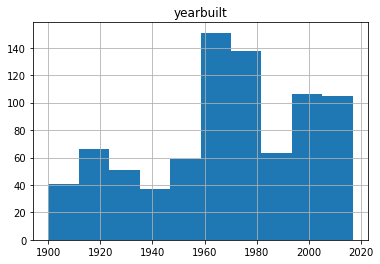

In [25]:
meta_df.hist(['yearbuilt'])